# Fine tuning with S-BERT

### Implementing the callback functions while training + k-fold cross validation

The models will have saved in this folder - https://drive.google.com/drive/folders/1ui5rywdrDdbBUeHph9AaA0VpfX01bbRe?usp=sharing



In [ ]:
'''
installing some extra libraries
'''

! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  sentence_transformers==1.0.2 \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg


from google.colab import drive
drive.mount('/content/drive')

'''
runtime restart is required for the libraries to be active in the notebook
'''

import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 112kB 11.0MB/s 
     |████████████████████████████████| 12.8MB 228kB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 1.1MB 38.6MB/s 
     |████████████████████████████████| 460kB 34.2MB/s 
     |████████████████████████████████| 9.1MB 34.7MB/s 
     |████████████████████████████████| 2.0MB 36.5MB/s 
     |████████████████████████████████| 1.2MB 25.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 419kB 35.8MB/s 
     |████████████████████████████████| 122kB 46.3MB/s 
     |████████████████████████████████| 3.2MB 33.8MB/s 
     |████████████████████████████████| 890kB 37.0MB/s 
     |████████████████████████████████| 1.8MB 33.1MB/s 
2021-03-31 09:07:21.066716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 569.7MB 29kB/s 
✔ Download and ins

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g465ahEE4G0fO1mfwXQUKcpTq92_l4S4txdr3fWniomw_Vdk22HRZI


In [1]:
import spacy

if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


In [2]:
!rm -rf policy-data-analyzer/

# Define branch to clone
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 771, done.
remote: Counting objects: 100% (771/771), done.
remote: Compressing objects: 100% (320/320), done.
remote: Total 5445 (delta 508), reused 694 (delta 449), pack-reused 4674
Receiving objects: 100% (5445/5445), 205.74 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (2819/2819), done.
Checking out files: 100% (1137/1137), done.


### For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [3]:
'''
importing all the required Python packages
importing modules from the GitHub repository as well
'''

import math, time
from typing import Iterable, Dict, Tuple, Type, Callable
import pandas as pd
import sys, os, csv, json, random, queue
import torch
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.metrics import classification_report
import transformers
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentencesDataset, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from torch.utils.data import DataLoader
import cupy as cp
import cupy as cp
import spacy

from sentence_transformers.evaluation import LabelAccuracyEvaluator, SentenceEvaluator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torch import device
import torch.multiprocessing as mp
from tqdm.autonotebook import trange
from statistics import mean

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error

from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.data_loading.src.utils import *
from tasks.model_evaluation.src.model_evaluator import *
from tasks.fine_tuning.sentence_transformer import EarlyStoppingSentenceTransformer
from tasks.data_augmentation.src.zero_shot_classification.fine_tuning_sbert import *
from tasks.data_visualization.src.plotting import *

Using the GPU


In [4]:
'''
defining a custom head Linear layer
'''

class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output

In [5]:
'''
define training functions
'''

def grid_search_fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names,
                                eval_classifier=None):
    """
    This function finds the optimal model with fine tuning
    """
    output_path = train_params["output_path"]
    experiment = train_params["experiment"]
    all_test_perc = train_params["all_test_perc"]
    model_names = train_params["model_names"]
    max_num_epochs = train_params["max_num_epochs"]
    baseline = train_params['baseline']
    patience = train_params['patience']
    seeds = train_params['seeds']

    numeric_labels = labels2numeric(test_labels, label_names)
    
    if eval_classifier is None:
        train_params["eval_classifier"] = "SBERT"
    else:
        train_params["eval_classifier"] = eval_classifier.__class__.__name__
    
    print(f"Grid Search Fine tuning parameters:\n{json.dumps(train_params, indent=4)}")

    json_output_fname = output_path + f"/{experiment}_FineTuningResults.json"

    # Output setup - we will update the json as the fine tuning process goes so every result is stored immediately
    with open(json_output_fname, "w") as f:
        json.dump({}, f)

    for test_perc in all_test_perc:
        with open(json_output_fname, "r") as fr:
            output = json.load(fr)

        output[f"test_perc={test_perc}"] = {}
        X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc,
                                                            stratify=train_labels, random_state=100)

        # Load data samples into batches
        train_batch_size = 16
        label2int = dict(zip(label_names, range(len(label_names))))
        train_samples = []
        for sent, label in zip(X_train, y_train):
            label_id = label2int[label]
            train_samples.append(InputExample(texts=[sent], label=label_id))

        # Configure the dev set evaluator - still need to test whether this works
        dev_samples = []
        for sent, label in zip(X_test, y_test):
            label_id = label2int[label]
            dev_samples.append(InputExample(texts=[sent], label=label_id))

        for model_name in model_names:
            # Setup
            output[f"test_perc={test_perc}"][f'model_name={model_name}']= {}

            # Train set config
            model = EarlyStoppingSentenceTransformer(model_name)
            train_dataset = SentencesDataset(train_samples, model=model)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

            
            for seed in seeds:
                # Setup
                output[f"test_perc={test_perc}"][f'model_name={model_name}'][f'seed={seed}'] = []

                # =============== SETTING GLOBAL SEEDS ===============================
                os.environ['PYTHONHASHSEED'] = str(seed)
                # Torch RNG
                torch.manual_seed(seed)
                # torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)
                # Python RNG
                np.random.seed(seed)
                random.seed(seed)
                # CuDA Determinism
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False
                torch.backends.cudnn.enabled = False
                # =============== SETTING GLOBAL SEEDS ===============================

                # Define the way the loss is computed
                classifier = SoftmaxClassifier(model=model,
                                            sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                            num_labels=len(label2int))

                # Dev set config
                dev_dataset = SentencesDataset(dev_samples, model=model)
                dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
                dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')

                # we don't need to loop over epochs anymore since that is not a hyperparameter
                warmup_steps = math.ceil(
                    len(train_dataset) * max_num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
                
                model_deets = f"{train_params['eval_classifier']}_model={model_name}_test-perc={test_perc}_n-epoch={max_num_epochs}_seed={seed}"
                
                # Train the model
                start = time.time()

                model.fit(train_objectives=[(train_dataloader, classifier)],
                            evaluator=dev_evaluator,
                            epochs=max_num_epochs,  # We always tune on an extra epoch to see the performance gain
                            evaluation_steps=1000,
                            warmup_steps=warmup_steps,
                            output_path=output_path,
                            BASELINE=baseline,
                            PATIENCE=patience,
                            params={'model_name': model_name, 'test_perc': test_perc, 'seed': seed}
                            )

                end = time.time()
                hours, rem = divmod(end - start, 3600)
                minutes, seconds = divmod(rem, 60)
                print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

                if eval_classifier is None:
                    evaluate_using_sbert(model, test_sents, test_labels, label_names,
                                            model_deets, model_name, max_num_epochs, numeric_labels, output,
                                            output_path, test_perc, json_output_fname, seed)
                else:
                    evaluate_using_sklearn(eval_classifier, model, train_sents, train_labels, test_sents,
                                            test_labels, label_names, model_deets, model_name, max_num_epochs,
                                            output, test_perc, output_path, json_output_fname, seed)


def evaluate_using_sbert(model, test_sents, test_labels, label_names,
                         model_deets, model_name, num_epochs, numeric_labels, output,
                         output_path, test_perc, json_output_fname, seed):
    # Projection matrix Z low-dim projection
    print("Classifying sentences...")
    proj_matrix = cp.asnumpy(calc_proj_matrix(test_sents, 50, es_nlp, model, 0.01))
    test_embs = encode_all_sents(test_sents, model, proj_matrix)
    label_embs = encode_labels(label_names, model, proj_matrix)
    
    # i = 0
    # # ===========
    # viz_string = f"{output_path}/{model_deets}_exp_{i}"
    # cm_string = f"{output_path}/{model_deets}_exp_{i}"
    # # ===========

    # while os.path.exists(viz_string):
    #     i += 1
    #     viz_string = f"{output_path}/{model_deets}_exp_{i}"
    #     cm_string = f"{output_path}/{model_deets}_exp_{i}"
        
    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")
    
    model_preds, model_scores = calc_all_cos_similarity(test_embs, label_embs, label_names)

    print("Evaluating predictions...")
    numeric_preds = labels2numeric(model_preds, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_labels, y_pred=numeric_preds)
    
    # with open(f"{results_save_path}/exp_num.txt") as f:
    #     exp = int(f.read())

    output[f"test_perc={test_perc}"][f'model_name={model_name}'][f'seed={seed}'].append(
        {"num_epochs": num_epochs,
         "avg_f1": evaluator.avg_f1.tolist()})

    # with open(f"{results_save_path}/exp_num.txt", "w") as f:
    #     f.write(str(exp+1))
    
    with open(json_output_fname, "w") as f:
        json.dump(output, f)
    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())


def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                           label_names, model_deets, model_name, num_epochs, output,
                           test_perc, output_path, json_output_fname, seed):
    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    # i = 0
    # # ===========
    # viz_string = f"{output_path}/{model_deets}_exp_{i}"
    # cm_string = f"{output_path}/{model_deets}_exp_{i}"
    # # ===========

    # while os.path.exists(viz_string):
    #     i += 1
    #     viz_string = f"{output_path}/{model_deets}_exp_{i}"
    #     cm_string = f"{output_path}/{model_deets}_exp_{i}"

    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    # with open(f"{results_save_path}/exp_num.txt") as f:
    #     exp = int(f.read())

    output[f"test_perc={test_perc}"][f'model_name={model_name}'][f'seed={seed}'].append(
        {"num_epochs": num_epochs,
         "avg_f1": evaluator.avg_f1.tolist()})

    # with open(f"{results_save_path}/exp_num.txt", "w") as f:
    #     f.write(str(exp+1))

    
    with open(json_output_fname, "w") as f:
        json.dump(output, f)

    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

# Data Loading

In [6]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 6

In [7]:
experiment = "EXP30"
classifier = "Binary"

base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/\
                                {classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}/"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)
# plot_data_distribution(numeric_train_labels, label_names)
# print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
# print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

Please do not overwrite existing models and their results from previous experiments
You are writing to Experiment # 6


# Grid Search Fine Tuning

Stores only the parameters used in the grid search, together with the results - no model is stored

Grid Search Fine tuning parameters:
{
    "all_test_perc": [
        0.2
    ],
    "model_names": [
        "paraphrase-xlm-r-multilingual-v1"
    ],
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/                                BinaryClassificationExperiments/6/",
    "experiment": 6,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "seeds": [
        12
    ],
    "eval_classifier": "SBERT"
}



Current Score is: 0.8209876543209876
Current ACC_LIST is: [1e-06, 0.8209876543209876]
Epoch: 0
Best score: 0.8209876543209876



Current Score is: 0.9506172839506173
Current ACC_LIST is: [0.8209876543209876, 0.9506172839506173]
Epoch: 1
Best score: 0.9506172839506173



Current Score is: 0.9382716049382716
Current ACC_LIST is: [0.8209876543209876, 0.9506172839506173, 0.9382716049382716]
Epoch: 2
Best score: 0.9506172839506173



Current Score is: 0.9567901234567902
Current ACC_LIST is: [0.8209876543209876, 0.9506172839506173, 0.9382716049382716, 0.9567901234567902]
Epoch: 3
Best score: 0.9567901234567902



Current Score is: 0.9506172839506173
Current ACC_LIST is: [0.8209876543209876, 0.9506172839506173, 0.9382716049382716, 0.9567901234567902, 0.9506172839506173]
Epoch: 4
Best score: 0.9567901234567902



Current Score is: 0.9444444444444444
Current ACC_LIST is: [0.8209876543209876, 0.9506172839506173, 0.9382716049382716, 0.9567901234567902, 0.9506172839506173, 0.9444444444444444]
Epoch: 5
Best score: 0.9567901234567902



Current Score is: 0.9259259259259259
Current ACC_LIST is: [0.8209876543209876, 0.9506172839506173, 0.9382716049382716, 0.9567901234567902, 0.9506172839506173, 0.9444444444444444, 0.9259259259259259]
Current score (0.9259259259259259) less than moving average (0.9481481481481482)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.9567901234567902


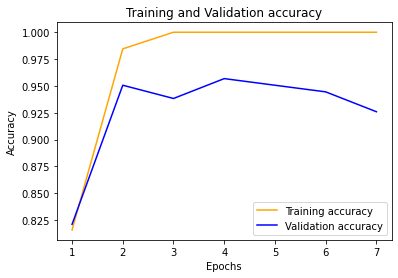

Time taken for fine-tuning: 00:04:55.01
Classifying sentences...


100%|██████████| 203/203 [00:06<00:00, 32.12it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 203 samples in 0.002s...
[t-SNE] Computed neighbors for 203 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 203 / 203
[t-SNE] Mean sigma: 7.357005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.581577
[t-SNE] KL divergence after 750 iterations: 0.412126


100%|██████████| 203/203 [00:00<00:00, 2342.00it/s]


Evaluating predictions...
Stored confusion matrix: /content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/                                BinaryClassificationExperiments/6//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


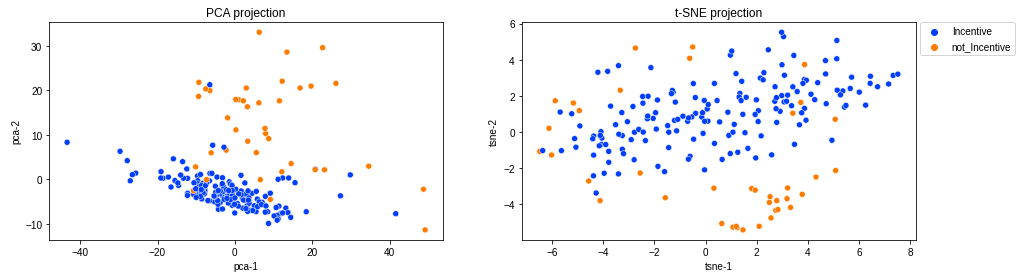

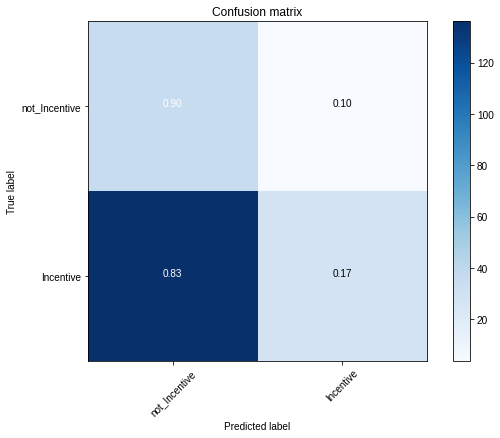

Macro/Weighted Avg F1-score: [0.30952380952380953, 0.29486277269528505]


In [8]:

grid_search_params = {
    "all_test_perc": [0.2],# 0.15, 0.25, 0.3],
    "model_names": ['paraphrase-xlm-r-multilingual-v1'], #'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "experiment": GLOBAL_EXPERIMENT_NUMBER,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "seeds": [12]
}

grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, test_sents, test_labels, label_names)

## Loading saved model

In [9]:
"""
loading saved model from results_save_path
"""

saved_model = EarlyStoppingSentenceTransformer(model_name_or_path=results_save_path)

str(saved_model)

'EarlyStoppingSentenceTransformer(\n  (0): Transformer(\n    (auto_model): XLMRobertaModel(\n      (embeddings): RobertaEmbeddings(\n        (word_embeddings): Embedding(250002, 768, padding_idx=1)\n        (position_embeddings): Embedding(514, 768, padding_idx=1)\n        (token_type_embeddings): Embedding(1, 768)\n        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n        (dropout): Dropout(p=0.1, inplace=False)\n      )\n      (encoder): RobertaEncoder(\n        (layer): ModuleList(\n          (0): RobertaLayer(\n            (attention): RobertaAttention(\n              (self): RobertaSelfAttention(\n                (query): Linear(in_features=768, out_features=768, bias=True)\n                (key): Linear(in_features=768, out_features=768, bias=True)\n                (value): Linear(in_features=768, out_features=768, bias=True)\n                (dropout): Dropout(p=0.1, inplace=False)\n              )\n              (output): RobertaSelfOutput(\n          

## Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [ ]:
# clf = LGBMClassifier(n_estimators=2000,
#                       feature_fraction=0.06,
#                       bagging_fraction=0.67,
#                       bagging_freq=1,
#                       verbose=0,
#                       n_jobs=6,
#                       random_state=69420)

# clf = svm.SVC(gamma=0.001, C=100.)

# clf = RandomForestClassifier(n_estimators=500,
#                             max_features=0.06,
#                             n_jobs=6,
#                             random_state=69420)